In [1]:
import sys
print(sys.executable)

C:\Users\JadinkaEnot\AppData\Local\Programs\Python\Python312\python.exe


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
from mnist import load_mnist  #mnist.py

# 1. загрузка данных
train, validation, test = load_mnist()

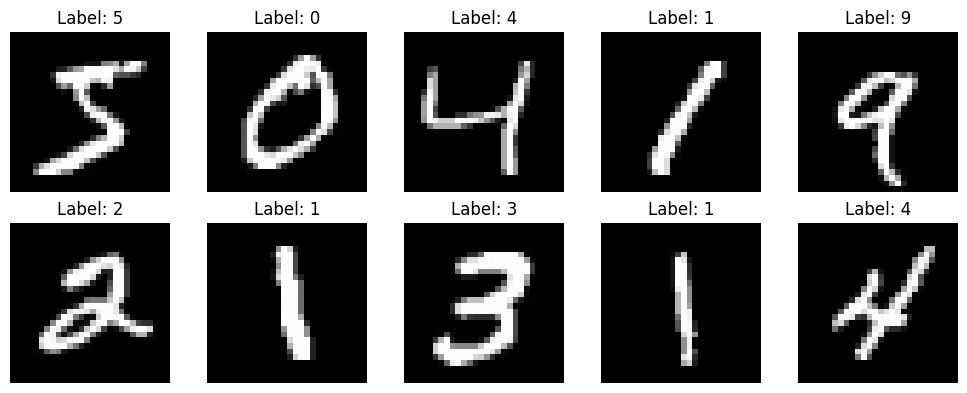

In [4]:
X_train_full, y_train_full = train
X_val, y_val = validation
X_test, y_test = test

# склеим train и validation, если хотите больше обучающих данных
X = np.vstack([X_train_full, X_val])
y = np.hstack([y_train_full, y_val])

# 2. визуализация нескольких изображений
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
class my_PCA:
    def __init__(self, n_components=None, use_svd=True):
        self.n_components = n_components
        self.use_svd = use_svd
        self.mean_ = None
        self.components_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        # 1. центрирование
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        n_samples = X.shape[0]

        if self.use_svd:
            # 2. SVD X_centered = U S V^T
            U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
            # собственные значения ковариационной матрицы
            eigvals = (S**2) / (n_samples - 1)
            components = Vt  # строки Vt — собственные векторы
        else:
            # классический путь: ковариация + eig
            cov = np.dot(X_centered.T, X_centered) / (n_samples - 1)
            eigvals, eigvecs = np.linalg.eig(cov)
            # сортировка по убыванию собственного значения
            idx = np.argsort(eigvals)[::-1]
            eigvals = eigvals[idx]
            eigvecs = eigvecs[:, idx]
            components = eigvecs.T  # строки — компоненты

        # ограничение числом компонент
        if self.n_components is not None:
            k = self.n_components
            components = components[:k]
            eigvals = eigvals[:k]

        self.components_ = components
        self.explained_variance_ = eigvals
        total_var = np.sum(eigvals)
        self.explained_variance_ratio_ = eigvals / total_var

        return self

    def transform(self, X):
        X_centered = X - self.mean_
        # проектирование в пространство главных компонент
        return np.dot(X_centered, self.components_.T)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

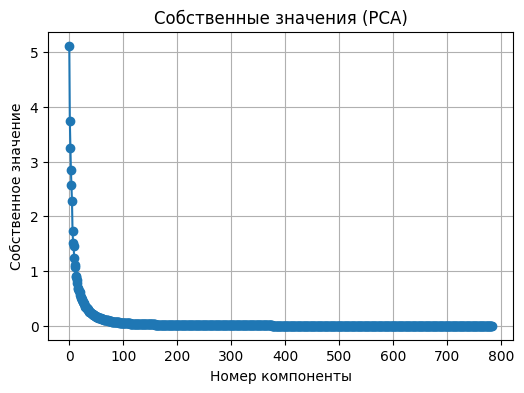

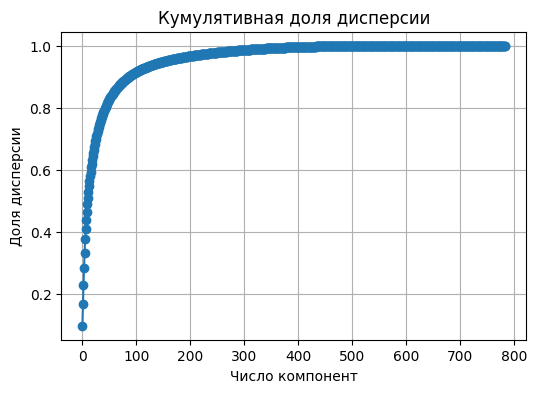

Доля дисперсии, объясняемая первыми 15 ГК: 0.5793


In [6]:
# обучаем PCA на полном X
pca_full = my_PCA(use_svd=True)  # без ограничения числа компонент
pca_full.fit(X)

eigvals = pca_full.explained_variance_
cum_var_ratio = np.cumsum(pca_full.explained_variance_ratio_)

# 1) график собственных значений
plt.figure(figsize=(6,4))
plt.plot(eigvals, marker='o')
plt.title("Собственные значения (PCA)")
plt.xlabel("Номер компоненты")
plt.ylabel("Собственное значение")
plt.grid(True)
plt.show()

# 2) график кумулятивной доли дисперсии
plt.figure(figsize=(6,4))
plt.plot(cum_var_ratio, marker='o')
plt.title("Кумулятивная доля дисперсии")
plt.xlabel("Число компонент")
plt.ylabel("Доля дисперсии")
plt.grid(True)
plt.show()

# доля дисперсии первых 15 компонент
k = 15
var_15 = np.sum(pca_full.explained_variance_ratio_[:k])
print(f"Доля дисперсии, объясняемая первыми {k} ГК: {var_15:.4f}")

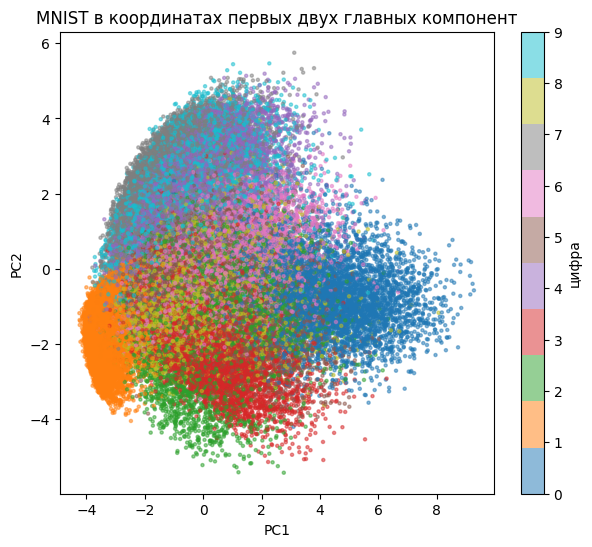

In [7]:
pca_2 = my_PCA(n_components=2, use_svd=True)
X_pca2 = pca_2.fit_transform(X)

plt.figure(figsize=(7,6))
scatter = plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=y, cmap='tab10', s=5, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("MNIST в координатах первых двух главных компонент")
plt.colorbar(scatter, ticks=range(10), label='цифра')
plt.show()

In [8]:
from collections import Counter

class my_kNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def _predict_one(self, x):
        # евклидово расстояние до всех обучающих
        # (можно оптимизировать, но так логика нагляднее)
        distances = np.linalg.norm(self.X_train - x, axis=1)
        # индексы k ближайших
        idx = np.argsort(distances)[:self.n_neighbors]
        nearest_labels = self.y_train[idx]
        # наиболее частый класс
        most_common = Counter(nearest_labels).most_common(1)[0][0]
        return most_common

    def predict(self, X):
        X = np.array(X)
        preds = [self._predict_one(x) for x in X]
        return np.array(preds)

In [9]:
# разбиение данных
X_train, X_test_small, y_train, y_test_small = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# возьмём поменьше данных, чтобы kNN не тормозил
X_small = X[:10000]
y_small = y[:10000]

X_train, X_test_small, y_train, y_test_small = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42, stratify=y_small
)

knn = my_kNN(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test_small)
acc = accuracy_score(y_test_small, y_pred)
print(f"Точность kNN на исходных данных (k=5): {acc:.4f}")

Точность kNN на исходных данных (k=5): 0.9425


In [12]:
# возьмём совсем небольшую выборку для подбора параметров
X_train_sub = X_train[:3000]
y_train_sub = y_train[:3000]
X_test_sub  = X_test_small[:1000]
y_test_sub  = y_test_small[:1000]

In [25]:
# чтобы ускорить, можно взять подмножество данных
# например, первые 10000 обучающих и 2000 тестовых (по желанию)
X_train_sub = X_train
y_train_sub = y_train
X_test_sub = X_test_small
y_test_sub = y_test_small

n_components_list = [10, 30, 50]
k_list = [1, 3, 5, 7, 9]

results = {}

for n_comp in n_components_list:
    pca = my_PCA(n_components=n_comp, use_svd=True)
    X_train_pca = pca.fit_transform(X_train_sub)
    X_test_pca = pca.transform(X_test_sub)

    for k in k_list:
        knn = my_kNN(n_neighbors=k)
        knn.fit(X_train_pca, y_train_sub)
        y_pred = knn.predict(X_test_pca)
        acc = accuracy_score(y_test_sub, y_pred)

        results[(n_comp, k)] = acc
        print(f"n_comp={n_comp}, k={k}, acc={acc:.4f}")

n_comp=10, k=1, acc=0.8800
n_comp=10, k=3, acc=0.8985
n_comp=10, k=5, acc=0.9040
n_comp=10, k=7, acc=0.8990
n_comp=10, k=9, acc=0.9020
n_comp=30, k=1, acc=0.9475
n_comp=30, k=3, acc=0.9520
n_comp=30, k=5, acc=0.9530
n_comp=30, k=7, acc=0.9505
n_comp=30, k=9, acc=0.9515
n_comp=50, k=1, acc=0.9535
n_comp=50, k=3, acc=0.9590
n_comp=50, k=5, acc=0.9525
n_comp=50, k=7, acc=0.9505
n_comp=50, k=9, acc=0.9500


In [26]:
best_params = max(results, key=results.get)
best_acc = results[best_params]
print(f"Лучшая точность: {best_acc:.4f} при n_components={best_params[0]}, k={best_params[1]}")

Лучшая точность: 0.9590 при n_components=50, k=3


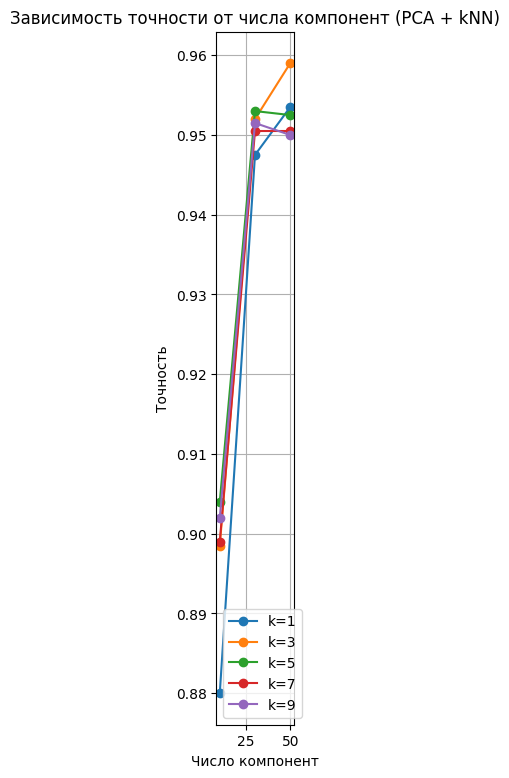

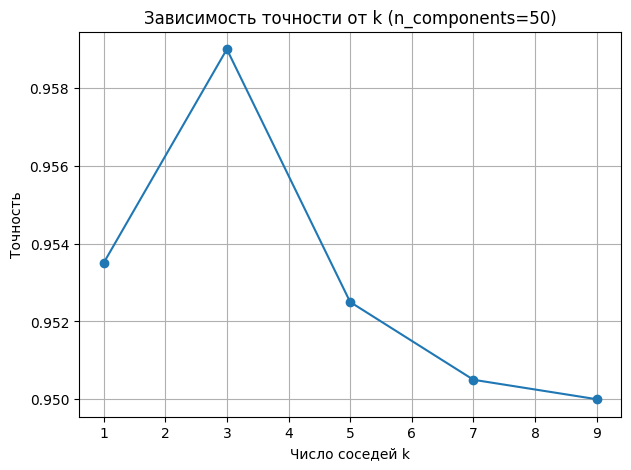

In [27]:
# график: точность от числа компонент при нескольких значениях k
plt.figure(figsize=(1, 9))
for k in k_list:
    accs = [results[(n_comp, k)] for n_comp in n_components_list]
    plt.plot(n_components_list, accs, marker='o', label=f"k={k}")
plt.xlabel("Число компонент")
plt.ylabel("Точность")
plt.title("Зависимость точности от числа компонент (PCA + kNN)")
plt.legend()
plt.grid(True)
plt.show()

# выберем одно число компонент (например, лучшее) и построим по k
best_n_comp = best_params[0]
plt.figure(figsize=(7,5))
accs_k = [results[(best_n_comp, k)] for k in k_list]
plt.plot(k_list, accs_k, marker='o')
plt.xlabel("Число соседей k")
plt.ylabel("Точность")
plt.title(f"Зависимость точности от k (n_components={best_n_comp})")
plt.grid(True)
plt.show()